In [2]:
import numpy as np

In [18]:
n = 100
D = np.arange(1, n+1)
U = np.random.randn(n, n)
U, _ = np.linalg.qr(U)
A = U.dot(np.diag(D)).dot(U.T)
b = np.random.randn(n)
eig_vals = np.linalg.eigvals(A)
print("Condition number = {}".format(np.max(eig_vals) / np.min(eig_vals)))

Condition number = 100.00000000000075


In [19]:
f = lambda x: 0.5 * x.T.dot(A.dot(x)) - b.dot(x)
gradf = lambda x: A.dot(x) - b
x0 = np.random.randn(n)

In [17]:
def grad_descent(f, grad, x0, num_iter, eps, alpha):
    x = x0.copy()
    conv = [x]
    for i in range(num_iter):
        h = -grad(x)
        if np.linalg.norm(h) < eps:
            break
        x = x + alpha * h
        conv.append(x)
    return x, conv

def heavy_ball(f, grad, x0, num_iter, eps, alpha, beta):
    x = x0.copy()
    conv = [x]
    prev_x = None
    for i in range(num_iter):
        h = -grad(x)
        if np.linalg.norm(h) < eps:
            break
        if prev_x is None:
            prev_x = x.copy()
            x = x + alpha * h
        else:
            x, prev_x = x + alpha * h + beta * (x - prev_x), x
            
        conv.append(x)
    return x, conv


def accelerated_gd(f, grad, x0, num_iter, eps, alpha):
    x = x0.copy()
    y = x0.copy()
    conv = [x]
    prev_x = None
    for i in range(num_iter):
        h = -grad(y)
        if np.linalg.norm(h) < eps:
            break
        if prev_x is None:
            prev_x = x.copy()
            x = y + alpha * h
        else:
            x, prev_x = y + alpha * h, x
        
        y = x + (i+1.) / (i+4.) * (x - prev_x)
            
        conv.append(x)
    return x, conv

def accelerated_gd_restart(f, grad, x0, num_iter, eps, alpha):
    x = x0.copy()
    y = x0.copy()
    conv = [x]
    prev_x = None
    for i in range(num_iter):
        h = -grad(y)
        if np.linalg.norm(h) < eps:
            break
        if prev_x is None:
            prev_x = x.copy()
            x = y + alpha * h
        else:
            x, prev_x = y + alpha * h, x
        if f(x) < f(prev_x):
            y = x + (i+1.) / (i+4.) * (x - prev_x)
        else:
            y = prev_x.copy()
            prev_x = None
            
        conv.append(x)
    return x, conv

In [4]:
def bb_method(f, gradf, x0, tol=1e-6, maxiter=100, callback=None, alpha_type=1):
    it = 0
    x_prev = x0.copy()
    current_tol = np.linalg.norm(gradf(x_prev))
    alpha = 1e-4
    while current_tol > tol and it < maxiter:
        it += 1
        current_grad = gradf(x_prev)
        if it != 1:
            g = current_grad - prev_grad
            if alpha_type == 1:
                alpha = g.dot(s) / g.dot(g)
            elif alpha_type == 2:
                alpha = s.dot(s) / g.dot(s)
        if callback:
            callback(x_prev)
        x_next = x_prev - alpha * current_grad
        current_tol = np.linalg.norm(gradf(x_next))
        prev_grad = current_grad
        s = x_next - x_prev
        x_prev = x_next
    if callback:
        callback(x_prev)
    return x_next

In [27]:
tol = 1e-8
max_iter = 2000


In [28]:
import scipy.optimize as scopt

print("\t Method BFGS Scipy")

scopt_conv = []
scopt_res = scopt.minimize(f, x0, method="BFGS", jac=gradf, callback=lambda x: scopt_conv.append(x), 
                           tol=tol, options={"maxiter": max_iter})
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

print("\t Method L-BFGS Scipy")

scopt_lbfgs_conv = []
scopt_res = scopt.minimize(f, x0, method="L-BFGS-B", jac=gradf, tol=tol, 
                           options={"maxiter": max_iter, 'maxcor': 10, "ftol": 1e-14, "gtol": 1e-10},
                           callback=lambda x: scopt_lbfgs_conv.append(x),
                           )
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

	 Method BFGS Scipy
Result: Optimization terminated successfully.
Convergence in 116 iterations
Function value = -2.322766162320935
	 Method L-BFGS Scipy
Result: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Convergence in 78 iterations
Function value = -2.3227661623208826


In [29]:
conv_bb = []

x_bb = bb_method(f, gradf, x0, tol=tol, maxiter=max_iter, callback=lambda x: conv_bb.append(x), alpha_type=1)
print(f(x_bb), len(conv_bb))

-2.322766162320936 123


In [30]:
x_gd, conv_gd = grad_descent(f, gradf, x0, max_iter, tol, 1. / n)
x_hb, conv_hb = heavy_ball(f, gradf, x0, max_iter, tol, 1. / n, 0.9)
x_acc_gd, conv_acc_gd = accelerated_gd(f, gradf, x0, max_iter, tol, 1. / n)

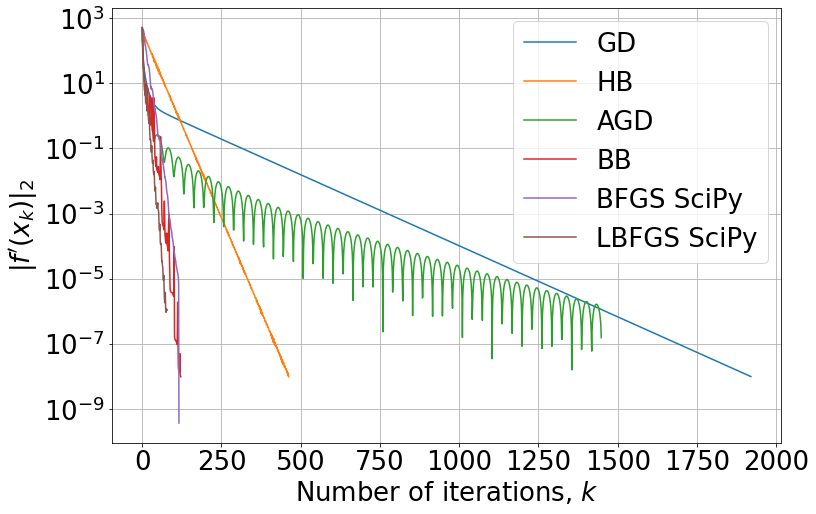

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
fontsize = 26

plt.semilogy([np.linalg.norm(gradf(x)) for x in conv_gd], label="GD")
plt.semilogy([np.linalg.norm(gradf(x)) for x in conv_hb], label="HB")
plt.semilogy([np.linalg.norm(gradf(x)) for x in conv_acc_gd], label="AGD")
plt.semilogy([np.linalg.norm(gradf(x)) for x in conv_bb], label="BB")

plt.semilogy([np.linalg.norm(gradf(x)) for x in [x0] + scopt_conv], label='BFGS SciPy')

plt.semilogy([np.linalg.norm(gradf(x)) for x in [x0] + scopt_lbfgs_conv], label='LBFGS SciPy')
plt.legend(fontsize=fontsize)
plt.ylabel("$\|f'(x_k)\|_2$", fontsize=fontsize)
plt.xlabel("Number of iterations, $k$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.grid(True)
_ = plt.yticks(fontsize=fontsize)

In [36]:

%timeit x_gd, conv_gd = grad_descent(f, gradf, x0, max_iter, tol, 1. / n)
%timeit x_hb, conv_hb = heavy_ball(f, gradf, x0, max_iter, tol, 1. / n, 0.9)
%timeit x_acc_gd, conv_acc_gd = accelerated_gd(f, gradf, x0, max_iter, tol, 1. / n)

%timeit bb_method(f, gradf, x0, tol=tol, maxiter=max_iter, callback=lambda x: conv_bb.append(x), alpha_type=1)
%timeit scopt.minimize(f, x0, method="BFGS", jac=gradf, tol=tol, options={"maxiter": max_iter})
%timeit scopt.minimize(f, x0, method="L-BFGS-B", jac=gradf, tol=tol, options={"maxiter": max_iter, 'maxcor': 10, "ftol": 1e-14, "gtol": 1e-10})

25.2 ms ± 800 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.18 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
23.1 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.5 ms ± 73.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
37.3 ms ± 3.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.68 ms ± 497 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
import sklearn.datasets as skldata
import scipy.optimize as scopt
import matplotlib.pyplot as plt
import numpy as np

n = 1000
m = 2000


X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3, random_state=42)
C = 1

In [41]:
@jax.jit
def f(w):
    return jnp.linalg.norm(w)**2 / 2 +  C * jnp.mean(jnp.logaddexp(jnp.zeros(X.shape[0]), -y * (X @ w)))

grad_f = jax.jit(jax.grad(f))
grad_f = jax.jit(jax.grad(f))
x0 = jnp.ones(n)
tol = 1e-7
max_iter = 1000
%timeit grad_f(x0).block_until_ready()

2.38 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
conv_bb = []

x_bb = bb_method(f, grad_f, x0, tol=tol, maxiter=max_iter, callback=lambda x: conv_bb.append(x), alpha_type=1)
print(f(x_bb), len(conv_bb))

0.4307869129693122 206


In [47]:
scopt_conv = []
scopt_res = scopt.minimize(f, x0, method="BFGS", jac=grad_f, callback=lambda x: scopt_conv.append(x), 
                           tol=tol, options={"maxiter": max_iter})
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

print("\t Method L-BFGS Scipy")

scopt_lbfgs_conv = []
x0 = np.ones(n)
scopt_res = scopt.minimize(f, x0, method="L-BFGS-B", jac=lambda x: np.array(grad_f(x)), tol=tol, 
                           options={"maxiter": max_iter, 'maxcor': 10, "ftol": 1e-10, "gtol": 1e-10},
                           callback=lambda x: scopt_lbfgs_conv.append(x)
                           )
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

Result: Optimization terminated successfully.
Convergence in 47 iterations
Function value = 0.4307869129693111
	 Method L-BFGS Scipy
Result: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Convergence in 69 iterations
Function value = 0.43078691345734177


In [45]:
x_gd, conv_gd = grad_descent(f, grad_f, x0, max_iter, tol, 1e-3)
x_hb, conv_hb = heavy_ball(f, grad_f, x0, max_iter, tol, 1e-3, 0.9)
x_acc_gd, conv_acc_gd = accelerated_gd(f, grad_f, x0, max_iter, tol, 1e-3)

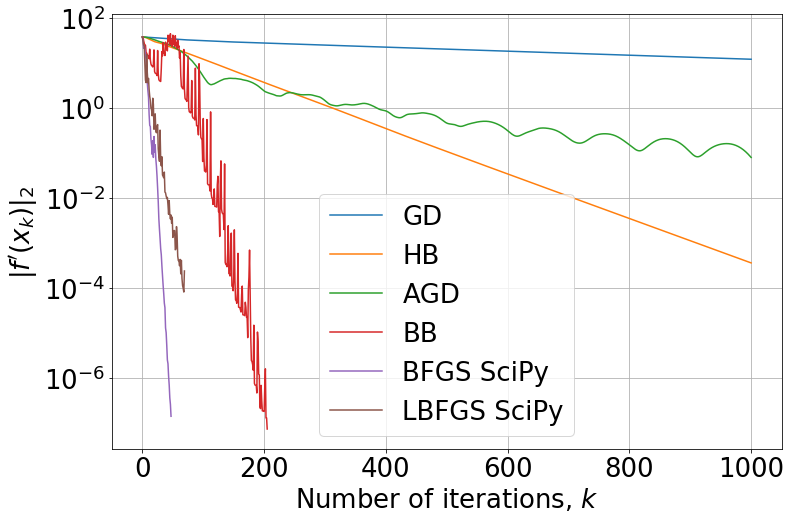

In [48]:
plt.figure(figsize=(12, 8))
fontsize = 26

plt.semilogy([np.linalg.norm(grad_f(x)) for x in conv_gd], label="GD")
plt.semilogy([np.linalg.norm(grad_f(x)) for x in conv_hb], label="HB")
plt.semilogy([np.linalg.norm(grad_f(x)) for x in conv_acc_gd], label="AGD")
plt.semilogy([np.linalg.norm(grad_f(x)) for x in conv_bb], label="BB")

plt.semilogy([np.linalg.norm(grad_f(x)) for x in [x0] + scopt_conv], label='BFGS SciPy')

plt.semilogy([np.linalg.norm(grad_f(x)) for x in [x0] + scopt_lbfgs_conv], label='LBFGS SciPy')
plt.legend(fontsize=fontsize)
plt.ylabel("$\|f'(x_k)\|_2$", fontsize=fontsize)
plt.xlabel("Number of iterations, $k$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.grid(True)
_ = plt.yticks(fontsize=fontsize)

In [49]:
%timeit x_gd, conv_gd = grad_descent(f, grad_f, x0, max_iter, tol, 1e-3)
%timeit x_hb, conv_hb = heavy_ball(f, grad_f, x0, max_iter, tol, 1e-3, 0.9)
%timeit x_acc_gd, conv_acc_gd = accelerated_gd(f, grad_f, x0, max_iter, tol, 1e-3)

%timeit bb_method(f, grad_f, x0, tol=tol, maxiter=max_iter, callback=lambda x: conv_bb.append(x), alpha_type=1)
%timeit scopt.minimize(f, x0, method="BFGS", jac=grad_f, tol=tol, options={"maxiter": max_iter})
%timeit scopt.minimize(f, x0, method="L-BFGS-B", jac=lambda x: np.array(grad_f(x)), tol=tol, options={"maxiter": max_iter, 'maxcor': 10, "ftol": 1e-10, "gtol": 1e-10}, callback=lambda x: scopt_lbfgs_conv.append(x))

2.75 s ± 311 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.14 s ± 348 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.01 s ± 143 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
789 ms ± 4.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.41 s ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
237 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
